<div style="width: 70%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/content/dam/news/images/noticies/2016/202-nova-marca-uoc.jpg", align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.882 · TFM</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencias de Datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">CARLOS ANDRES RIVERA RIVERA</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

# TMP: Threat Hunting

## Introducción

En este notebook, abordamos la detección de anomalías en el tráfico web utilizando técnicas avanzadas de ciencia de datos. A través de este proceso, buscamos identificar comportamientos inusuales que podrían indicar posibles amenazas cibernéticas. Los pasos clave que cubriremos incluyen:

1. **Extracción de Datos:** Utilizaremos datos de transacciones web extraídos de la plataforma New Relic, una herramienta líder en monitoreo y gestión del rendimiento de aplicaciones.
   
2. **Preprocesamiento de Datos:** Limpiaremos y estructuraremos los datos extraídos, incluyendo la codificación de variables categóricas y la imputación de valores faltantes.

3. **Detección de Anomalías:** Implementaremos el modelo Isolation Forest para identificar transacciones anómalas. Este modelo es efectivo para detectar comportamientos inusuales en grandes volúmenes de datos.

4. **Notificación de Anomalías:** Automatizaremos la notificación de anomalías detectadas mediante el envío de correos electrónicos detallados, permitiendo una respuesta rápida por parte del equipo de seguridad.

5. **Almacenamiento de Resultados:** Los datos procesados y las anomalías detectadas se guardarán en archivos CSV para su análisis posterior y generación de reportes.

El objetivo principal de este análisis es mejorar la seguridad de las aplicaciones web mediante la identificación proactiva de posibles amenazas, utilizando un enfoque basado en datos y técnicas avanzadas de machine learning.


### Cargar los datos

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Cargar los datos
file_path = 'data-newrelic.csv'  # Cambia esto por la ruta de tu archivo
data = pd.read_csv(file_path)

## Lectura del conjunto de datos

In [470]:
file_path = 'data-newrelic.csv'  
data = pd.read_csv(file_path)

## Visualización del conjunto de datos

In [472]:
# Visualizamos los tipos de cada uno de los atributos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Timestamp                        5000 non-null   object 
 1   App ID                           5000 non-null   int64  
 2   App Name                         5000 non-null   object 
 3   Container ID                     5000 non-null   object 
 4   Duration                         5000 non-null   float64
 5   Entity.GUID                      353 non-null    object 
 6   Entity GUID                      5000 non-null   object 
 7   Error                            5000 non-null   bool   
 8   External Call Count              4689 non-null   float64
 9   External Duration                4689 non-null   float64
 10  GUID                             5000 non-null   object 
 11  Host                             5000 non-null   object 
 12  Http.Status Code    

In [434]:
data.head(10)

,Timestamp,App ID,App Name,Container ID,Duration,Entity.GUID,Entity GUID,Error,External Call Count,External Duration,...,Response.Headers.Content Type,Sampled,Tags.Account,Tags.Account ID,Tags.Trusted Account ID,Total Time,Trace ID,Transaction Sub Type,Transaction Type,Web Duration
0,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,d995833596ac0e5d1b2bea2b47fe16b746a3f144b58e48...,0.630829,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.546005,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.662885,3d333b1581ddd735a33dc9f2da13242a,Expressjs,Web,0.630829
1,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,377a3d356c6a40be3ec90f6f3c1aacf68370988dc91c21...,0.001951,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,NaN,NaN,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.002123,b8de364b94094047b34d47d6df223ae1,Expressjs,Web,0.001951
2,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,4dcbdbae89dcd2800d51fc48ca0ed000b2acdd038e4607...,0.440226,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,3.0,0.404612,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.441388,e87cbd8f56ec55aca4270ff1837b789f,Expressjs,Web,0.440226
3,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,377a3d356c6a40be3ec90f6f3c1aacf68370988dc91c21...,0.628030,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.603724,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.681870,eb410f416da2aa3df0f71a847ffd3b06,Expressjs,Web,0.628030
4,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,ad5a43f8210c773a032baa86f67392d572dc94dfb24026...,0.646765,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.624565,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.703668,7ffa7937e6be4b69cf3334b68b1aae9a,Expressjs,Web,0.646765
5,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,f9bdaa09a436b329eb22a06a941cf52b35b05cb3697cde...,0.198589,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.155937,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.215665,efa5b8a74b5adde03dae8d595156b391,Expressjs,Web,0.198589
6,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,94858c4a0a194b8b0448ba7d1247105b29ad1906a922fb...,0.451491,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.393468,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.512114,6bfa90b2c11593ca0fd73df05829c996,Expressjs,Web,0.451491
7,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,94858c4a0a194b8b0448ba7d1247105b29ad1906a922fb...,0.529600,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.436171,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.545668,d5586b0150935ae9fe4e4c97951953b5,Expressjs,Web,0.529600
8,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,e3fa9d24732a0eac9e89e1e609e3ea5a93bc11a2c1246c...,0.206651,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.207516,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.223348,35a19c796f37bf2d2402a346303f9cf3,Expressjs,Web,0.206651
9,2024-06-06 21:34:59,1340265931,shops.vpp-frontend,fbf2c139c370777c17444601e9f6cd0e773e3cde03600a...,0.374427,NaN,OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx,False,4.0,0.293778,...,text/html; charset=utf-8,False,ML Fury,989586,1709707,0.428263,bab4588a2f0b151f9af31258c467d5a5,Expressjs,Web,0.374427


In [471]:
print("Numero de características:", len(data.columns))
print("Longitud del conjunto de datos:", len(data))

Numero de características: 36
Longitud del conjunto de datos: 5000


### Análisis del balanceo

In [451]:
# Análisis del balanceo de variables categóricas
print("Distribución de 'Real Agent ID':")
print(data['Real Agent ID'].value_counts())

Distribución de 'Real Agent ID':
Real Agent ID
1697787162    226
1700970966    224
1699123073    219
1711904605    218
1699096230    218
1697118628    215
1697121590    214
1697120059    213
1697788336    213
1697785067    213
1709005837    212
1700936310    211
1697117679    210
1640197778    208
1697784870    207
1697058864    206
1633950424    205
1709128520    204
1697118093    203
1746194827    195
1697783091    195
1699104545    194
1699166334    190
1668650732    187
Name: count, dtype: int64


In [452]:
print("\nDistribución de 'Entity GUID':")
print(data['Entity GUID'].value_counts())


Distribución de 'Entity GUID':
Entity GUID
OTg5NTg2fEFQTXxBUFBMSUNBVElPTnwxMzQwMjY1OTMx    4999
ewrewrewrewrewrwer                                 1
Name: count, dtype: int64


In [453]:
print("\nDistribución de 'Container ID':")
print(data['Container ID'].value_counts())


Distribución de 'Container ID':
Container ID
24c213157bfcd35e13900812272e4577536a68dce7891061371b29a6496a0117    226
97283a80cad71a6933ae7dc0b99ea5b122b53fdd615f701146e6ab7bfcf2884e    224
088121604d52e1c00972c1d8d1448ea17455fa274c26f4b8aeddb6818f4a510c    219
d995833596ac0e5d1b2bea2b47fe16b746a3f144b58e48bf3e6edbeab7ad51d5    218
94858c4a0a194b8b0448ba7d1247105b29ad1906a922fb1745d50ba21c053cf6    218
0c9fb3c874f62f98f14905bc704c11318acc2c40525b5b6e6e3d68fc5f54dc9e    215
80f1a9e7d8c27a7c0718d59af5496694517e425ea2c5f9173e3f386e6714f28b    214
47744e9912d17f754733ef7cde699b571b3a9913aaf259112ff35c2810212593    213
377a3d356c6a40be3ec90f6f3c1aacf68370988dc91c21faecc0228dde774799    213
9808538f46b1807bda672322e14f2847ea1da09fd574c4b6ea14f6838dbb40cd    213
9048fe8872f44444e2443703b999e11057a3f444171262647c11b69c1e9d4784    212
aa06f44e5d93e706305c4124065d761cf4e742d777e7ddd973996cfd0e0a88de    211
f9bdaa09a436b329eb22a06a941cf52b35b05cb3697cdefb99cb1de24c1f78ec    210
e9609f971757d27200

In [454]:
print("\nDistribución de 'Host':")
print(data['Host'].value_counts())


Distribución de 'Host':
Host
i-0834c4aad6d14cca6-10.54.154.140    226
i-018079451c4215236-10.52.138.227    224
i-081459ae591de7b40-10.50.223.70     219
i-09d041639b11d18b7-10.54.97.174     218
i-017612d8b8320058c-10.50.51.243     218
i-0431b2f3e9764fa10-10.50.72.43      215
i-0cf461579aafcd06e-10.52.149.180    214
i-0c01b3691ff3000c4-10.50.76.72      213
i-0fbeb67c4d97a5350-10.54.176.219    213
i-0c6a0fc08ebc4fd65-10.52.141.165    213
i-0321540e615072fd6-10.50.255.235    212
i-002a7e31d746efd17-10.50.120.71     211
i-00cb96bb3f7ed52c6-10.54.143.197    210
i-0abea15c5b924c98a-10.50.42.135     208
i-0f72d96d0ae2d0246-10.52.220.149    207
i-0a5561bda62166cb2-10.50.243.207    206
i-088b25323143f05b8-10.52.201.192    205
i-06c147cbaaae09f84-10.50.55.43      204
i-086c4f1be48cbb644-10.50.165.42     203
i-004ddf00049e8cf23-10.52.204.238    195
i-0014e1a130bffd690-10.50.160.147    195
i-025bd67d4d2297185-10.50.136.141    194
i-0acb97056c06b5465-10.54.102.142    190
i-04b1fa71068a86cbe-10.54.7

In [483]:
print("Distribución de 'Real Agent ID':")
print(data['Real Agent ID'].value_counts())

Distribución de 'Real Agent ID':
Real Agent ID
1697787162    226
1700970966    224
1699123073    219
1711904605    218
1699096230    218
1697118628    215
1697121590    214
1697120059    213
1697788336    213
1697785067    213
1709005837    212
1700936310    211
1697117679    210
1640197778    208
1697784870    207
1697058864    206
1633950424    205
1709128520    204
1697118093    203
1746194827    195
1697783091    195
1699104545    194
1699166334    190
1668650732    187
Name: count, dtype: int64


In [484]:
print("Distribución de 'Request.Method':")
print(data['Request.Method'].value_counts())

Distribución de 'Request.Method':
Request.Method
GET     4972
POST      24
HEAD       4
Name: count, dtype: int64


In [474]:
data.describe()

,App ID,Duration,External Call Count,External Duration,Http.Status Code,Priority,Real Agent ID,Request.Headers.Content Length,Response.Headers.Content Length,Tags.Account ID,Tags.Trusted Account ID,Total Time,Web Duration
count,5.000000e+03,5000.000000,4689.000000,4689.000000,5000.000000,5000.000000,5.000000e+03,24.000000,7.160000e+02,5000.0,5000.0,5000.000000,5000.000000
mean,1.340266e+09,0.413558,3.614417,0.381636,215.085400,0.574820,1.695450e+09,354.583333,5.009820e+04,989586.0,1709707.0,0.449444,0.413558
std,0.000000e+00,0.185813,0.801138,0.138384,37.022386,0.388416,2.105628e+07,117.254430,1.591398e+05,0.0,0.0,0.200601,0.185813
min,1.340266e+09,0.001210,1.000000,0.000758,200.000000,0.000088,1.633950e+09,266.000000,2.000000e+00,989586.0,1709707.0,0.001498,0.001210
25%,1.340266e+09,0.359349,3.000000,0.334797,200.000000,0.266246,1.697119e+09,304.750000,1.860000e+02,989586.0,1709707.0,0.396923,0.359349
50%,1.340266e+09,0.460017,4.000000,0.406516,200.000000,0.543980,1.697787e+09,323.000000,4.075000e+02,989586.0,1709707.0,0.497583,0.460017
75%,1.340266e+09,0.519748,4.000000,0.459637,200.000000,0.811215,1.700936e+09,348.250000,8.720000e+02,989586.0,1709707.0,0.568103,0.519748
max,1.340266e+09,1.403891,5.000000,1.378704,404.000000,1.999338,1.746195e+09,747.000000,1.203099e+06,989586.0,1709707.0,1.414386,1.403891


In [512]:
X_reduced = data[["Real Agent ID", 
                  "Entity GUID", 
                  "Container ID", 
                  #"External Call Count", 
                  "Host",
                  "Timestamp",
                  "Request.URI",
                  "Request.Method"]].copy()

In [526]:
# Codificar las variables categóricas
encoder_real_agent = LabelEncoder().fit(data["Real Agent ID"])
encoder_entity_guid = LabelEncoder().fit(data["Entity GUID"])
encoder_container_id = LabelEncoder().fit(data["Container ID"])
encoder_host = LabelEncoder().fit(data["Host"])
encoder_request_method = LabelEncoder().fit(data["Request.Method"])

# Almacenar los encoders en un diccionario
encoders = {
    'Real Agent ID': encoder_real_agent,
    'Entity GUID': encoder_entity_guid,
    'Container ID': encoder_container_id,
    'Host': encoder_host,
    'Request.Method': encoder_request_method
}

X_reduced['Real_Agent_ID_Encoded'] = encoder_real_agent.transform(X_reduced['Real Agent ID'])
X_reduced['Entity_GUID_Encoded'] = encoder_entity_guid.transform(X_reduced['Entity GUID'])
X_reduced['Container_ID_Encoded'] = encoder_container_id.transform(X_reduced['Container ID'])
X_reduced['Host_Encoded'] = encoder_host.transform(X_reduced['Host'])
X_reduced['Request_Method_Encoded'] = encoder_request_method.transform(X_reduced['Request.Method'])

# Normalizar los datos
scaler = StandardScaler()
X_reduced[['Real_Agent_ID_Encoded', 
           'Entity_GUID_Encoded', 
           'Container_ID_Encoded', 
           'Host_Encoded',
           'Request_Method_Encoded']] = scaler.fit_transform(
    X_reduced[['Real_Agent_ID_Encoded', 
               'Entity_GUID_Encoded', 
               'Container_ID_Encoded', 
               'Host_Encoded',
               'Request_Method_Encoded']]
)


In [520]:
def send_email_alert(subject, body):
    sender_email = "XXXXX"
    receiver_email = "XXXXX"
    password = "XXXXX"

    # Crear el mensaje de correo electrónico
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Adjuntar el cuerpo del mensaje
    message.attach(MIMEText(body, "plain"))

    # Conectar al servidor SMTP de Gmail
    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, message.as_string())
        print("Correo enviado exitosamente.")
    except Exception as e:
        print(f"Error al enviar el correo: {e}")

In [527]:
# Configurar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.01, max_samples=5000)

# Ajustar el modelo
iso_forest.fit(X_reduced[['Real_Agent_ID_Encoded', 
                          'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']])

# Predecir anomalías (-1 para anomalías, 1 para normales)
X_reduced['anomaly'] = iso_forest.predict(X_reduced[['Real_Agent_ID_Encoded', 
                                                     'Entity_GUID_Encoded', 
                                                     'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']])

# Filtrar las anomalías detectadas
anomalies = X_reduced[X_reduced['anomaly'] == -1]
anomalies_count = len(anomalies)
print("Anomalías detectadas:", anomalies_count)

# Guardar anomalías en un archivo CSV
anomalies.to_csv('anomalies_detected.csv', index=False)

# Calcular estadísticas de las características normales para comparación
normal_data = X_reduced[X_reduced['anomaly'] == 1]
normal_stats = normal_data[['Real_Agent_ID_Encoded', 
                            'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']].median()

# Identificar la columna que originó la anomalía
def detect_anomaly_reason(row, normal_stats):
    reasons = []
    for column in ['Real_Agent_ID_Encoded', 
                   'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']:
        if row[column] > normal_stats[column]:
            reasons.append(column)
    return reasons

# Asignar la razón de la anomalía usando .loc de forma segura
anomalies.loc[:, 'anomaly_reason'] = anomalies.apply(lambda row: detect_anomaly_reason(row, normal_stats), axis=1)

# Enviar correo si se detectan anomalías
if anomalies_count > 0:
    subject = "Alerta de Anomalía Detectada"
    body = f"Se han detectado {anomalies_count} anomalías en el tráfico de la web.\n\nDetalles de las anomalías:\n"
    for index, row in anomalies.iterrows():
        body += f"Timestamp: {data.loc[index, 'Timestamp']}, Real Agent ID: {data.loc[index, 'Real Agent ID']}, Entity GUID: {data.loc[index, 'Entity GUID']}, Container ID: {data.loc[index, 'Container ID']}, Host: {data.loc[index, 'Request.Headers.Host']}\n"
        body += f"Razón de la anomalía: {row['anomaly_reason']}\n"
        body += "\n"
    send_email_alert(subject, body)
else:
    print("No se han detectado anomalías.")


Anomalías detectadas: 29


/var/folders/b4/41h6j7px379_f3m9cxf36879chh60t/T/ipykernel_39582/2882889698.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies.loc[:, 'anomaly_reason'] = anomalies.apply(lambda row: detect_anomaly_reason(row, normal_stats), axis=1)


Correo enviado exitosamente.


In [547]:
def predict_new_data(new_data_file_path, iso_forest, encoders, scaler):
    # Cargar nuevos datos
    new_data = pd.read_csv(new_data_file_path)
    print("Numero de características:", len(new_data.columns))
    print("Longitud del conjunto de datos:", len(new_data))
    
    # Función para codificar y manejar valores desconocidos
    def transform_with_unknown(encoder, data):
        encoded = []
        for item in data:
            if item in encoder.classes_:
                encoded.append(encoder.transform([item])[0])
            else:
                # Asignar un valor especial para valores desconocidos
                encoded.append(-1)
        return encoded
    
    # Codificar las variables categóricas con los encoders entrenados
    new_data['Real_Agent_ID_Encoded'] = transform_with_unknown(encoders['Real Agent ID'], new_data['Real Agent ID'])
    new_data['Entity_GUID_Encoded'] = transform_with_unknown(encoders['Entity GUID'], new_data['Entity GUID'])
    new_data['Container_ID_Encoded'] = transform_with_unknown(encoders['Container ID'], new_data['Container ID'])
    new_data['Host_Encoded'] = transform_with_unknown(encoders['Host'], new_data['Host'])
    new_data['Request_Method_Encoded'] = transform_with_unknown(encoders['Request.Method'], new_data['Request.Method'])
    
    # Normalizar los datos con el scaler entrenado
    new_data[['Real_Agent_ID_Encoded', 'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']] = scaler.transform(
        new_data[['Real_Agent_ID_Encoded', 'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']]
    )
    
    # Predecir anomalías
    new_data['anomaly'] = iso_forest.predict(new_data[['Real_Agent_ID_Encoded', 'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']])
    
    # Filtrar y mostrar anomalías
    anomalies = new_data[new_data['anomaly'] == -1]
    anomalies_count = len(anomalies)
    print("Anomalías detectadas en los nuevos datos:", anomalies_count)
    
    # Calcular estadísticas de las características normales para comparación
    normal_data = new_data[new_data['anomaly'] == 1]
    normal_stats = normal_data[['Real_Agent_ID_Encoded', 'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']].median()
    
    # Identificar la columna que originó la anomalía
    def detect_anomaly_reason(row, normal_stats):
        reasons = []
        for column in ['Real_Agent_ID_Encoded', 'Entity_GUID_Encoded', 'Container_ID_Encoded', 'Host_Encoded', 'Request_Method_Encoded']:
            if row[column] > normal_stats[column]:
                reasons.append(column)
        return reasons
    
    # Asignar la razón de la anomalía usando .loc de forma segura
    anomalies.loc[:, 'anomaly_reason'] = anomalies.apply(lambda row: detect_anomaly_reason(row, normal_stats), axis=1)
    
    # Enviar correo si se detectan anomalías
    if anomalies_count > 0:
        subject = "Alerta de Anomalía Detectada en Nuevos Datos"
        body = f"Se han detectado {anomalies_count} anomalías en los nuevos datos.\n\nDetalles de las anomalías:\n"
        for index, row in anomalies.iterrows():
            body += f"Timestamp: {new_data.loc[row.name, 'Timestamp']}, Real Agent ID: {new_data.loc[row.name, 'Real Agent ID']}, Entity GUID: {new_data.loc[row.name, 'Entity GUID']}, Container ID: {new_data.loc[row.name, 'Container ID']}, Host: {new_data.loc[row.name, 'Host']}\n"
            body += f"Razón de la anomalía: {row['anomaly_reason']}\n"
            body += "\n"
        send_email_alert(subject, body)
    else:
        print("No se han detectado anomalías en los nuevos datos.")
    
    return anomalies

# Llamar a la función con los nuevos datos
new_data_file_path = 'table.csv'  # Reemplaza con la ruta de tu archivo de nuevos datos
anomalies = predict_new_data(new_data_file_path, iso_forest, encoders, scaler)

# Opcional: Guardar las anomalías detectadas en un archivo CSV
anomalies.to_csv('new_anomalies_detected.csv', index=False)


Numero de características: 39
Longitud del conjunto de datos: 5000
Anomalías detectadas en los nuevos datos: 39


/var/folders/b4/41h6j7px379_f3m9cxf36879chh60t/T/ipykernel_39582/365782137.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies.loc[:, 'anomaly_reason'] = anomalies.apply(lambda row: detect_anomaly_reason(row, normal_stats), axis=1)


Correo enviado exitosamente.



Resumen estadístico de variables numéricas:
          Duration  External Call Count  External Duration   Total Time  \
count  5000.000000          4689.000000        4689.000000  5000.000000   
mean      0.413558             3.614417           0.381636     0.449444   
std       0.185813             0.801138           0.138384     0.200601   
min       0.001210             1.000000           0.000758     0.001498   
25%       0.359349             3.000000           0.334797     0.396923   
50%       0.460017             4.000000           0.406516     0.497583   
75%       0.519748             4.000000           0.459637     0.568103   
max       1.403891             5.000000           1.378704     1.414386   

       Http.Status Code  Response.Headers.Content Length  
count       5000.000000                     7.160000e+02  
mean         215.085400                     5.009820e+04  
std           37.022386                     1.591398e+05  
min          200.000000                    

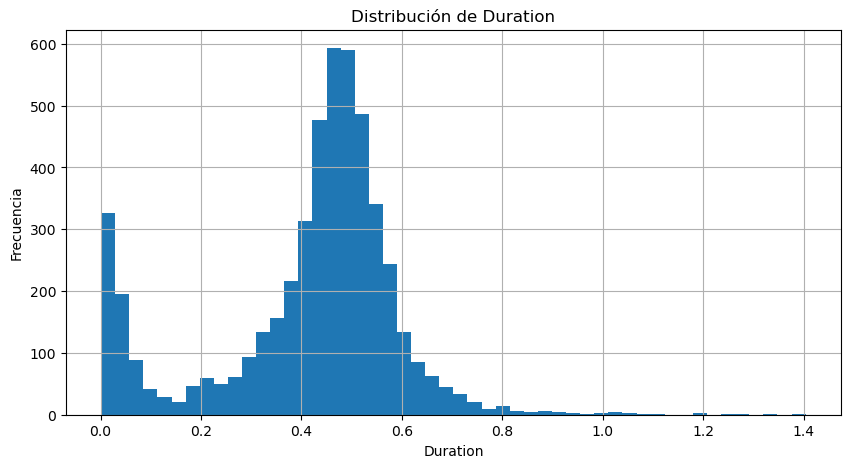

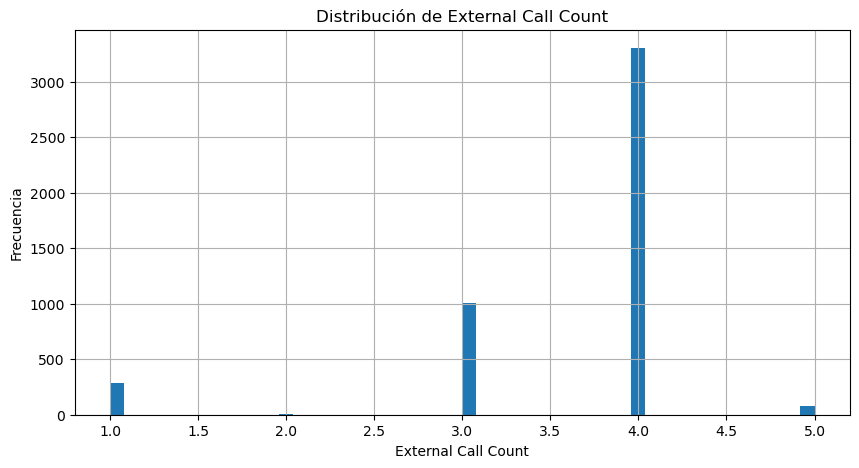

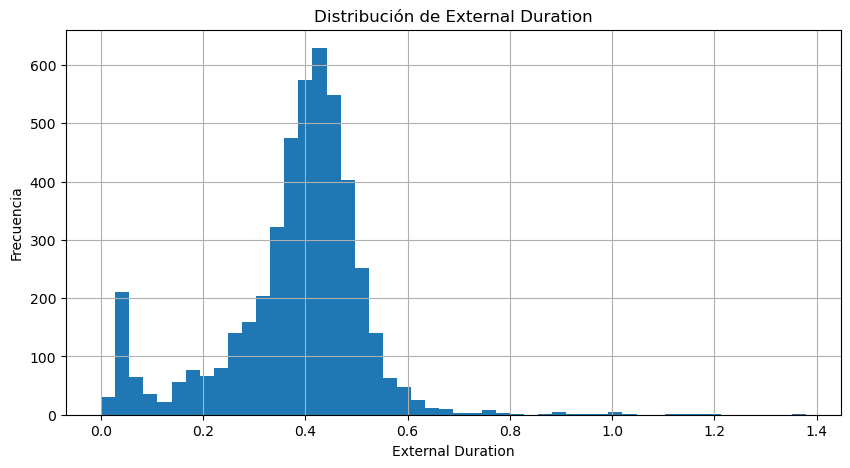

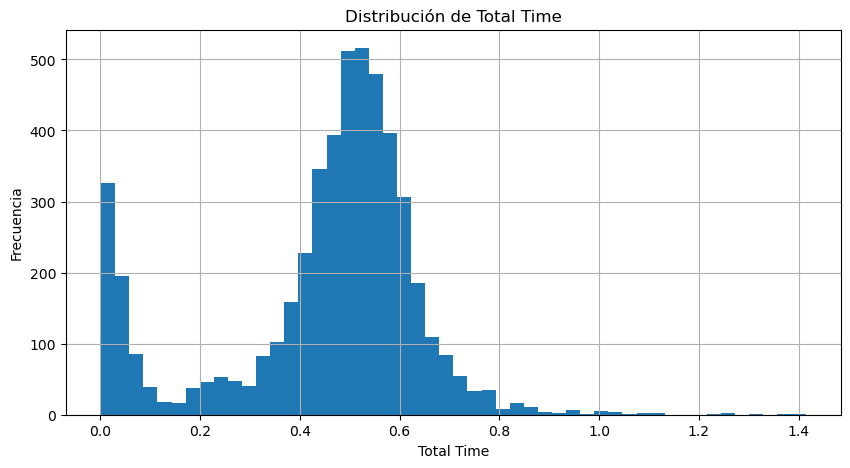

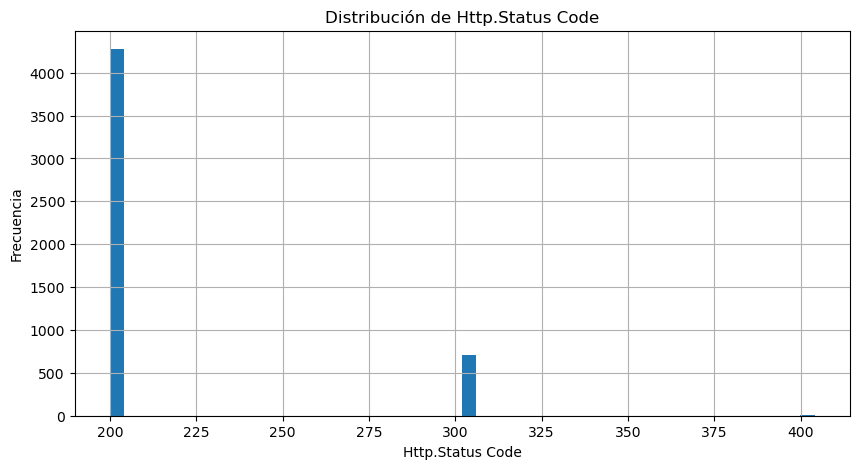

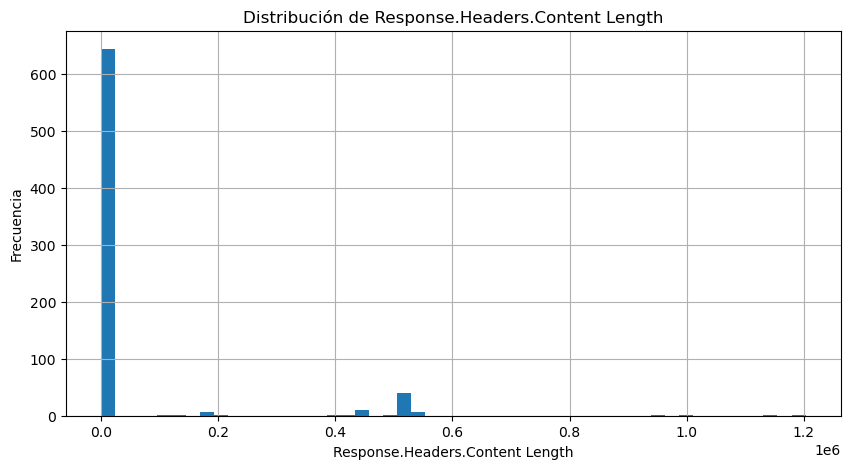


Resumen estadístico de variables numéricas:
       Real Agent ID
count   5.000000e+03
mean    1.695450e+09
std     2.105628e+07
min     1.633950e+09
25%     1.697119e+09
50%     1.697787e+09
75%     1.700936e+09
max     1.746195e+09


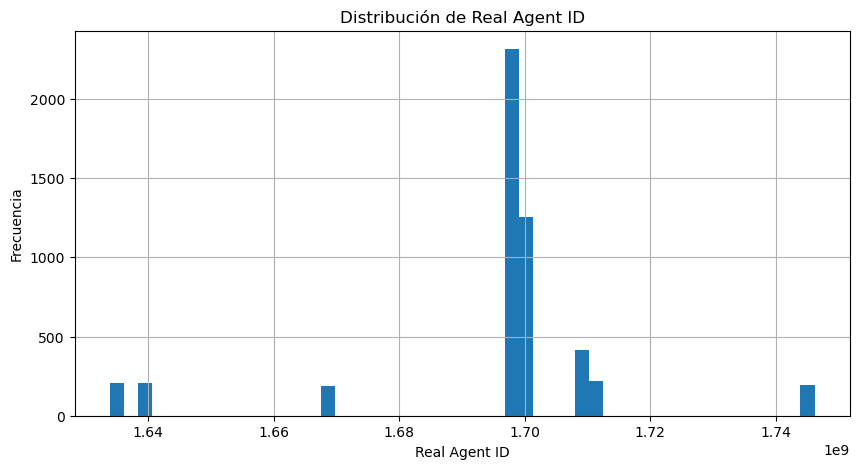

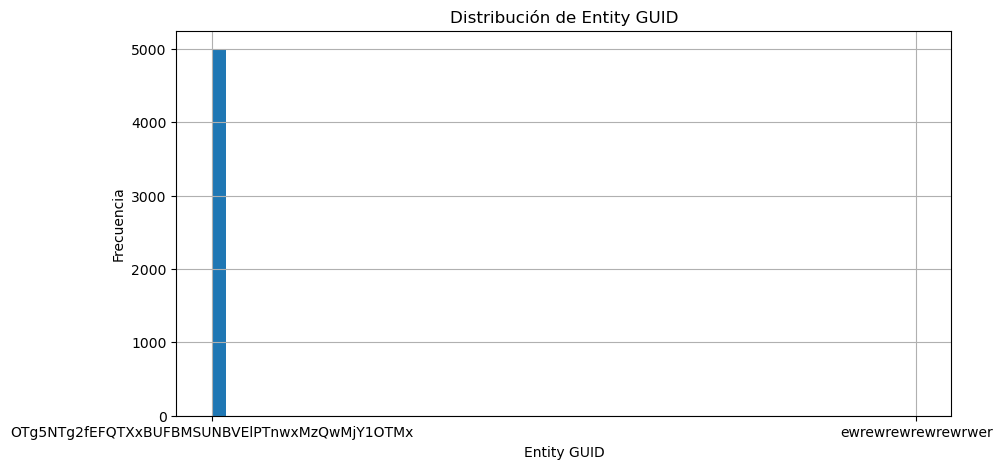

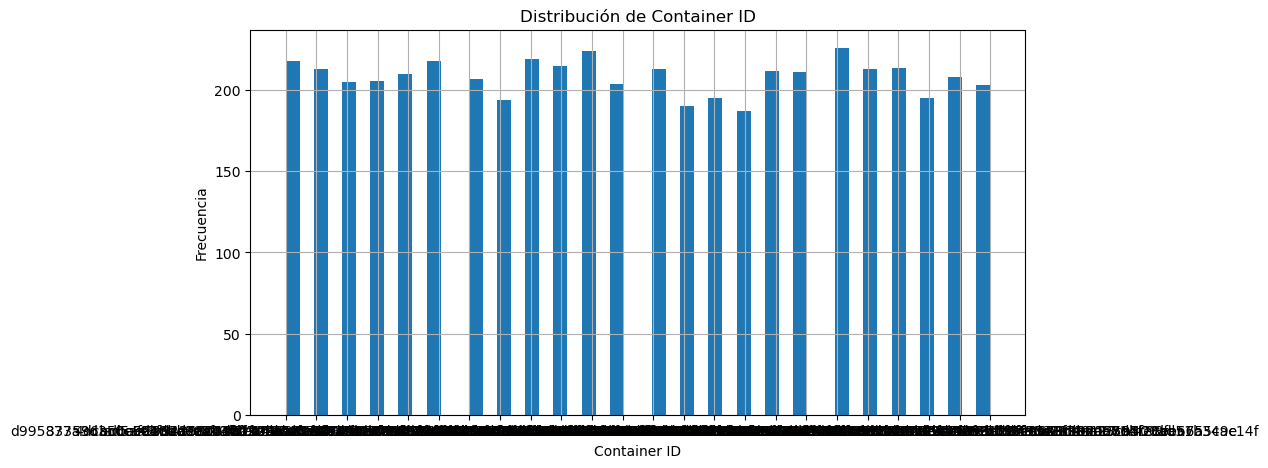

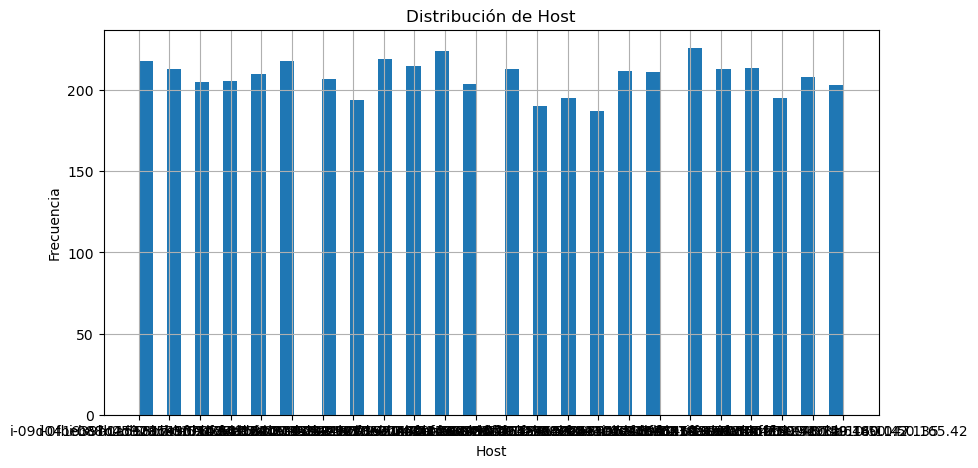

In [550]:
# Análisis del balanceo de variables numéricas
numeric_columns = ['Duration', 'External Call Count', 'External Duration', 'Total Time', 'Http.Status Code', 'Response.Headers.Content Length']
print("\nResumen estadístico de variables numéricas:")
print(data[numeric_columns].describe())

# Visualización de distribuciones
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    data[column].hist(bins=50)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()
    
# Análisis del balanceo de variables numéricas
numeric_columns = ['Real Agent ID', 'Entity GUID', 'Container ID', 'Host']
print("\nResumen estadístico de variables numéricas:")
print(data[numeric_columns].describe())

# Visualización de distribuciones
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    data[column].hist(bins=50)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()
